# Dog Breed Identification CNN

In [1]:
!pip install watermark

In [2]:
# Watermark
%load_ext watermark
%watermark -v -m -p tensorflow,numpy

CPython 3.6.8
IPython 5.5.0

tensorflow 1.14.0
numpy 1.16.4

compiler   : GCC 8.0.1 20180414 (experimental) [trunk revision 259383
system     : Linux
release    : 4.14.79+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


In [ ]:
# Imports
from datetime import datetime
import os
import pickle
import tarfile
from time import time

from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Directories
base_dir = '.'

data_dir = os.path.join(base_dir, 'data')
processed_dir = os.path.join(data_dir, 'processed')
train_dir = os.path.join(processed_dir, 'train')
test_dir = os.path.join(processed_dir, 'test')

In [ ]:
# Functions
def plot_train_result(data, metric, ax=None):
    """Helper to plot training result curves."""
    if not ax:
        ax = plt.gca()
    ax.plot(data[metric], label='Train')
    ax.plot(data[f"val_{metric}"], label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.set_title(f"Training process: {metric}")
    ax.legend()
    ax.grid()
    return ax

In [ ]:
# Extract uploaded data (if needed)
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)
    print('[INFO] Extracting data... ', end='', flush=True)
    with tarfile.open('./dog-data.tar.gz', 'r:*') as archive:
        archive.extractall(processed_dir)
    print('DONE.')

In [7]:
# Create the generators for the input data
input_size = (299, 299)
batch_size = 64

# - Data generators
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    rotation_range=20
)
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# - Flow from directory generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=input_size, batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=input_size, batch_size=batch_size,
    class_mode='categorical'
)

Found 18519 images belonging to 120 classes.
Found 2061 images belonging to 120 classes.


In [17]:
# Build the model
# - Construct the base model
base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet', include_top=False
)

# - Only let the last inception block be trained
base_model.trainable = True
for layer in base_model.layers[:-62]:
    layer.trainable = False

# - Construct the full model
model = keras.Sequential([
    # - InceptionV3 base
    base_model,
    # - A pooling layer
    keras.layers.GlobalAveragePooling2D(),
    # - First dense layer
    keras.layers.Dense(1024, activation='relu'),
    # - Dropout layer
    keras.layers.Dropout(0.5),
    # - Second dense layer
    keras.layers.Dense(512, activation='relu'),
    # - Second dropout layer
    keras.layers.Dropout(0.3),
    # - Output layer
    keras.layers.Dense(120, activation='softmax')
])

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)              

In [ ]:
# Configure logging with TensorBoard and checkpoints
log_dir = os.path.abspath(os.path.join(
    base_dir, 'logs', f"{datetime.today():%Y%m%d}-{round(time())}"
))
cp_dir = os.path.join(log_dir, 'checkpoints')
os.makedirs(log_dir)
os.mkdir(cp_dir)

cb_tboard = keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=0, update_freq='batch'
)
cb_checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(cp_dir, 'init.{epoch:02d}.hdf5'),
    save_weights_only=True, verbose=1
)
callbacks = [cb_tboard, cb_checkpoint]

In [10]:
# Train the model
epochs = 10

history = model.fit_generator(
    train_generator, epochs=epochs, shuffle=True, callbacks=callbacks,
    validation_data=test_generator
)
with open(os.path.join(cp_dir, 'history.pkl'), 'wb') as fout:
    pickle.dump(history.history, fout)

Epoch 1/10
289/290 [============================>.] - ETA: 1s - loss: 2.4617 - acc: 0.3717
Epoch 00001: saving model to /content/logs/20190804-1564951605/checkpoints/init.01.hdf5
290/290 [==============================] - 352s 1s/step - loss: 2.4593 - acc: 0.3722 - val_loss: 1.4975 - val_acc: 0.6099
Epoch 2/10
289/290 [============================>.] - ETA: 1s - loss: 1.3481 - acc: 0.6064
Epoch 00002: saving model to /content/logs/20190804-1564951605/checkpoints/init.02.hdf5
290/290 [==============================] - 338s 1s/step - loss: 1.3481 - acc: 0.6065 - val_loss: 1.0587 - val_acc: 0.7181
Epoch 3/10
289/290 [============================>.] - ETA: 1s - loss: 1.1223 - acc: 0.6704
Epoch 00003: saving model to /content/logs/20190804-1564951605/checkpoints/init.03.hdf5
290/290 [==============================] - 342s 1s/step - loss: 1.1234 - acc: 0.6701 - val_loss: 1.0027 - val_acc: 0.7171
Epoch 4/10
289/290 [============================>.] - ETA: 1s - loss: 0.9547 - acc: 0.7163
Epoch 

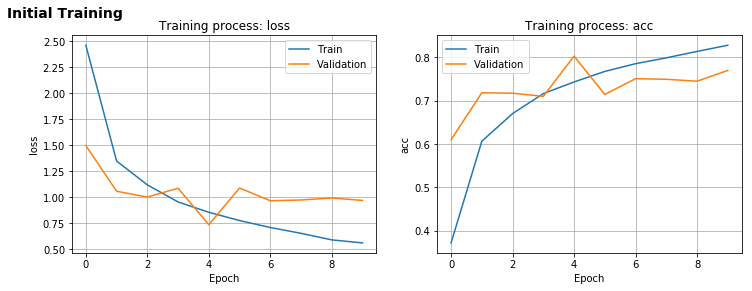

In [11]:
# Training result plots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plot_train_result(history.history, 'loss', ax=axs[0])
plot_train_result(history.history, 'acc', ax=axs[1])

fig.suptitle('Initial Training', x=0.05, ha='left', fontsize=14, 
             fontweight='bold');

In [ ]:
# Load from a checkpoint
epoch = 4
with open(os.path.join(cp_dir, 'history.pkl'), 'rb') as fin:
    history = pickle.load(fin)
model.load_weights(os.path.join(cp_dir, f'init.{epoch:02d}.hdf5'))

In [19]:
# Unfreeze another inception block
base_model.trainable = True
for layer in base_model.layers[:-(62+19)]:
    layer.trainable = False

# - Recompile the model
model.compile(optimizer=keras.optimizers.SGD(lr=0.0025), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)              

In [20]:
# Fine-tune the model
# - Tag the checkpoints with 'fine' instead of 'init'
cb_checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(cp_dir, 'fine.{epoch:02d}.hdf5'),
    save_weights_only=True, verbose=1
)
callbacks = [cb_tboard, cb_checkpoint]

# - Run the fitting process
epochs = 20

history_fine = model.fit_generator(
    train_generator, epochs=epochs, shuffle=True, callbacks=callbacks,
    validation_data=test_generator
)
with open(os.path.join(cp_dir, 'history_fine.pkl'), 'wb') as fout:
    pickle.dump(history_fine.history, fout)

Epoch 1/20
289/290 [============================>.] - ETA: 1s - loss: 0.7848 - acc: 0.7568
Epoch 00001: saving model to /content/logs/20190804-1564951605/checkpoints/fine.01.hdf5
290/290 [==============================] - 350s 1s/step - loss: 0.7838 - acc: 0.7571 - val_loss: 0.7409 - val_acc: 0.7768
Epoch 2/20
289/290 [============================>.] - ETA: 1s - loss: 0.6983 - acc: 0.7828
Epoch 00002: saving model to /content/logs/20190804-1564951605/checkpoints/fine.02.hdf5
290/290 [==============================] - 333s 1s/step - loss: 0.6977 - acc: 0.7828 - val_loss: 0.7068 - val_acc: 0.7855
Epoch 3/20
289/290 [============================>.] - ETA: 1s - loss: 0.6649 - acc: 0.7939
Epoch 00003: saving model to /content/logs/20190804-1564951605/checkpoints/fine.03.hdf5
290/290 [==============================] - 333s 1s/step - loss: 0.6653 - acc: 0.7936 - val_loss: 0.6880 - val_acc: 0.7948
Epoch 4/20
289/290 [============================>.] - ETA: 1s - loss: 0.6490 - acc: 0.7988
Epoch 

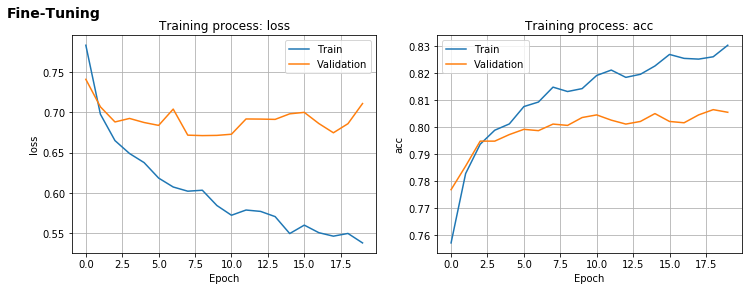

In [21]:
# Plot fine-tuning results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plot_train_result(history_fine.history, 'loss', ax=axs[0])
plot_train_result(history_fine.history, 'acc', ax=axs[1])

fig.suptitle('Fine-Tuning', x=0.05, ha='left', fontsize=14, 
             fontweight='bold');

In [ ]:
# Load from a checkpoint
epoch = 10
with open(os.path.join(cp_dir, 'history_fine.pkl'), 'rb') as fin:
    history_fine = pickle.load(fin)
model.load_weights(os.path.join(cp_dir, f'fine.{epoch:02d}.hdf5'))

In [ ]:
# Combine the history objects from the 2 phases
tmp_hist = history.copy()
mid_epoch = len(tmp_hist)
for k in tmp_hist:
    tmp_hist[k].extend(history_fine[k])

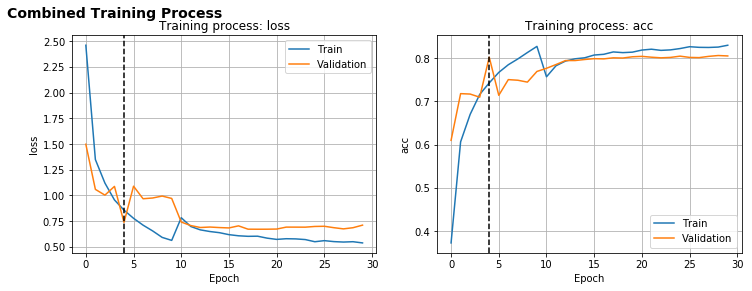

In [27]:
# Plot the combined training process history
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = plot_train_result(tmp_hist, 'loss', ax=axs[0])
ax.axvline(mid_epoch, color='black', linestyle='--')

ax = plot_train_result(tmp_hist, 'acc', ax=axs[1])
ax.axvline(mid_epoch, color='black', linestyle='--')

fig.suptitle('Combined Training Process', x=0.05, ha='left', 
             fontsize=14, fontweight='bold');

In [ ]:
# Download results
e_init = 4
e_fine = 10
with tarfile.open('results.tar.gz', 'w:gz') as archive:
    archive.add(os.path.join(cp_dir, f"init.{e_init:02d}.hdf5"), 
                'init_model.hdf5')
    archive.add(os.path.join(cp_dir, 'history.pkl'), 'history.pkl')
    archive.add(os.path.join(cp_dir, f"fine.{e_fine:02d}.hdf5"), 
                'fine_model.hdf5')
    archive.add(os.path.join(cp_dir, 'history_fine.pkl'), 'history_fine.pkl')
files.download('results.tar.gz')